In [1]:
import os
import tensorflow as tf
import keras
from keras.applications import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
import keras.layers as layers

Notebook run using keras: 2.14.0


## Constants

In [2]:
index = 2

### Model

In [3]:
model = Xception(weights='imagenet')
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

### Preprocess 

In [4]:
#Preprocess function
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

### Show images

In [5]:
folder_path = 'images'

# List all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

# Load and preprocess all images in the folder
images = transform_img_fn(image_files)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images'

In [ ]:
# Change the index value for different images, /2 + 0.5 is to show the image in the correct color
plt.imshow(images[index] / 2 + 0.5)

In [7]:
# Augmentation function
def apply_augmentation(images):
    augmentation = keras.Sequential([
        layers.RandomBrightness(0.5, value_range=(0, 1), seed=42),
        layers.RandomContrast(0.5, seed=42),
        layers.RandomFlip("horizontal_and_vertical", seed=42),
        layers.RandomRotation(0.5, seed=42),
    ])
    aug_images = augmentation(images)
    return aug_images

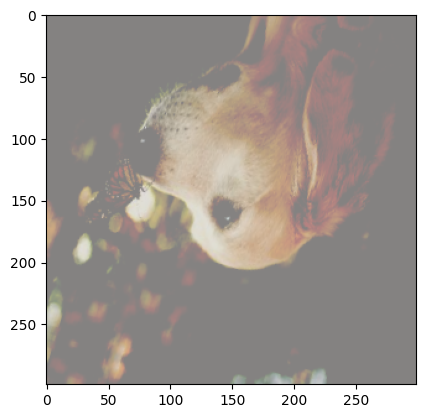

In [8]:
aug_images = apply_augmentation(images)

# Change the index value for different images, /2 + 0.5 is to show the image in the correct color
plt.imshow(aug_images[index] / 2 + 0.5)

### List Decoded Predictions

In [9]:
# Original image
preds = model.predict(images)

# Change the index value for different images
for x in decode_predictions(preds)[index]:
    print(x)

1/1 [==============================] - 2s 2s/step
('n02099601', 'golden_retriever', 0.7357675)
('n02099712', 'Labrador_retriever', 0.033836655)
('n02104029', 'kuvasz', 0.018768135)
('n02111500', 'Great_Pyrenees', 0.00675754)
('n04409515', 'tennis_ball', 0.003806553)


In [10]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
def to_numpy(tensor):
    return tensor.numpy() if hasattr(tensor, 'numpy') else tensor

aug_images = to_numpy(aug_images)

In [11]:
# Augmented image
preds = model.predict(aug_images)

# Change the index value for different images
for x in decode_predictions(preds)[index]:
    print(x)

1/1 [==============================] - 1s 951ms/step
('n02099601', 'golden_retriever', 0.4968668)
('n02088364', 'beagle', 0.1275964)
('n02102177', 'Welsh_springer_spaniel', 0.06306046)
('n02102318', 'cocker_spaniel', 0.05650237)
('n02089867', 'Walker_hound', 0.044976212)


## Lime Explainer

In [80]:
explainer = lime_image.LimeImageExplainer()

# Change the index value for different images, and its going to take a while
explanation = explainer.explain_instance(images[index].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
aug_explanation = explainer.explain_instance(aug_images[index].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 828ms/step


  1%|          | 10/1000 [00:00<01:36, 10.29it/s]

1/1 [==============================] - 1s 813ms/step


  2%|▏         | 20/1000 [00:01<01:34, 10.40it/s]

1/1 [==============================] - 1s 871ms/step


  3%|▎         | 30/1000 [00:02<01:35, 10.16it/s]

1/1 [==============================] - 1s 782ms/step


  4%|▍         | 40/1000 [00:03<01:31, 10.47it/s]

1/1 [==============================] - 1s 776ms/step


  5%|▌         | 50/1000 [00:04<01:28, 10.74it/s]

1/1 [==============================] - 1s 748ms/step


  6%|▌         | 60/1000 [00:05<01:25, 11.03it/s]

1/1 [==============================] - 1s 741ms/step


  7%|▋         | 70/1000 [00:06<01:22, 11.26it/s]

1/1 [==============================] - 1s 754ms/step


  8%|▊         | 80/1000 [00:07<01:21, 11.34it/s]

1/1 [==============================] - 1s 764ms/step


  9%|▉         | 90/1000 [00:08<01:21, 11.15it/s]

1/1 [==============================] - 1s 968ms/step


 11%|█         | 108/1000 [00:09<01:07, 13.30it/s]

1/1 [==============================] - 1s 1s/step


 11%|█         | 111/1000 [00:10<01:46,  8.38it/s]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 120/1000 [00:12<01:52,  7.85it/s]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 130/1000 [00:13<01:51,  7.83it/s]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 140/1000 [00:14<01:51,  7.69it/s]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 150/1000 [00:15<01:50,  7.70it/s]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 168/1000 [00:17<01:25,  9.76it/s]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 171/1000 [00:19<02:06,  6.56it/s]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 180/1000 [00:20<02:05,  6.53it/s]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 190/1000 [00:21<01:56,  6.97it/s]

1/1 [==============================] - 1s 1s/step


 20%|██        | 200/1000 [00:22<01:49,  7.27it/s]

1/1 [==============================] - 1s 1s/step


 21%|██        | 210/1000 [00:24<01:45,  7.49it/s]

1/1 [==============================] - 1s 1s/step


 22%|██▎       | 225/1000 [00:25<01:25,  9.08it/s]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 238/1000 [00:27<01:20,  9.46it/s]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 242/1000 [00:28<01:51,  6.82it/s]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 250/1000 [00:29<01:50,  6.82it/s]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 260/1000 [00:30<01:40,  7.38it/s]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 270/1000 [00:32<01:35,  7.63it/s]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 280/1000 [00:33<01:32,  7.78it/s]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 290/1000 [00:34<01:29,  7.95it/s]

1/1 [==============================] - 1s 1s/step


 30%|███       | 300/1000 [00:35<01:27,  8.00it/s]

1/1 [==============================] - 1s 1s/step


 31%|███       | 310/1000 [00:36<01:25,  8.04it/s]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 320/1000 [00:38<01:23,  8.11it/s]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 330/1000 [00:39<01:22,  8.09it/s]

1/1 [==============================] - 1s 994ms/step


 35%|███▍      | 349/1000 [00:40<00:58, 11.06it/s]

1/1 [==============================] - 1s 986ms/step


 35%|███▌      | 353/1000 [00:41<01:17,  8.34it/s]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 360/1000 [00:42<01:25,  7.49it/s]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 376/1000 [00:44<01:08,  9.13it/s]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 380/1000 [00:45<01:32,  6.72it/s]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 395/1000 [00:47<01:15,  8.04it/s]

1/1 [==============================] - 1s 1s/step


 41%|████      | 408/1000 [00:48<01:02,  9.43it/s]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 415/1000 [00:50<01:22,  7.05it/s]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 426/1000 [00:52<01:19,  7.24it/s]

1/1 [==============================] - 1s 1s/step


 44%|████▎     | 436/1000 [00:54<01:17,  7.28it/s]

1/1 [==============================] - 1s 1s/step


 45%|████▍     | 446/1000 [00:55<01:12,  7.66it/s]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 454/1000 [00:57<01:20,  6.82it/s]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 466/1000 [00:58<01:05,  8.20it/s]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 477/1000 [01:00<00:58,  8.91it/s]

1/1 [==============================] - 1s 981ms/step


 48%|████▊     | 481/1000 [01:01<01:22,  6.30it/s]

1/1 [==============================] - 1s 1s/step


 50%|████▉     | 497/1000 [01:02<00:55,  9.13it/s]

1/1 [==============================] - 1s 982ms/step


 51%|█████     | 506/1000 [01:04<00:57,  8.65it/s]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 510/1000 [01:05<01:24,  5.80it/s]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 526/1000 [01:07<01:01,  7.69it/s]

1/1 [==============================] - 1s 1s/step


 54%|█████▎    | 537/1000 [01:08<00:56,  8.22it/s]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 547/1000 [01:10<00:55,  8.11it/s]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 557/1000 [01:12<00:59,  7.40it/s]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 566/1000 [01:13<00:59,  7.28it/s]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 577/1000 [01:15<00:51,  8.27it/s]

1/1 [==============================] - 1s 1s/step


 59%|█████▊    | 587/1000 [01:16<00:50,  8.22it/s]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 598/1000 [01:18<00:47,  8.41it/s]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 609/1000 [01:20<00:48,  8.04it/s]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 619/1000 [01:21<00:52,  7.29it/s]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 623/1000 [01:23<01:12,  5.21it/s]

1/1 [==============================] - 1s 1s/step


 64%|██████▎   | 637/1000 [01:24<00:48,  7.43it/s]

1/1 [==============================] - 1s 1s/step


 65%|██████▍   | 649/1000 [01:26<00:40,  8.63it/s]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 653/1000 [01:27<00:58,  5.92it/s]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 667/1000 [01:29<00:41,  7.95it/s]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 677/1000 [01:30<00:41,  7.86it/s]

1/1 [==============================] - 1s 1s/step


 69%|██████▊   | 687/1000 [01:32<00:41,  7.51it/s]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 697/1000 [01:34<00:41,  7.36it/s]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 707/1000 [01:36<00:40,  7.28it/s]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 718/1000 [01:37<00:33,  8.39it/s]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 722/1000 [01:38<00:46,  5.97it/s]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 735/1000 [01:40<00:40,  6.51it/s]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 746/1000 [01:42<00:38,  6.60it/s]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 758/1000 [01:44<00:30,  8.06it/s]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 768/1000 [01:46<00:31,  7.32it/s]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 772/1000 [01:48<00:50,  4.49it/s]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 786/1000 [01:50<00:35,  6.02it/s]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 795/1000 [01:52<00:36,  5.67it/s]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 807/1000 [01:53<00:26,  7.31it/s]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 817/1000 [01:55<00:25,  7.17it/s]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 827/1000 [01:56<00:22,  7.73it/s]

1/1 [==============================] - 1s 1s/step


 84%|████████▎ | 837/1000 [01:58<00:19,  8.35it/s]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 849/1000 [01:59<00:15,  9.47it/s]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 854/1000 [02:01<00:22,  6.44it/s]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 860/1000 [02:02<00:25,  5.59it/s]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 876/1000 [02:04<00:16,  7.66it/s]

1/1 [==============================] - 1s 1s/step


 89%|████████▊ | 887/1000 [02:05<00:13,  8.44it/s]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 897/1000 [02:07<00:12,  8.17it/s]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 901/1000 [02:08<00:18,  5.42it/s]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 918/1000 [02:10<00:09,  8.35it/s]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 929/1000 [02:12<00:08,  8.08it/s]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 939/1000 [02:13<00:07,  8.26it/s]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 943/1000 [02:15<00:09,  5.77it/s]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 957/1000 [02:16<00:05,  7.85it/s]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 967/1000 [02:17<00:04,  8.16it/s]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 971/1000 [02:19<00:04,  5.89it/s]

1/1 [==============================] - 1s 1s/step


 99%|█████████▊| 987/1000 [02:20<00:01,  8.29it/s]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 997/1000 [02:22<00:00,  8.49it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 806ms/step


  1%|          | 10/1000 [00:00<01:37, 10.18it/s]

1/1 [==============================] - 1s 896ms/step


  3%|▎         | 28/1000 [00:02<01:07, 14.40it/s]

1/1 [==============================] - 1s 993ms/step


  4%|▍         | 38/1000 [00:03<01:26, 11.14it/s]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 42/1000 [00:04<02:19,  6.85it/s]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 56/1000 [00:06<01:52,  8.43it/s]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 66/1000 [00:08<01:54,  8.19it/s]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 76/1000 [00:09<01:48,  8.54it/s]

1/1 [==============================] - 1s 1s/step


  9%|▊         | 87/1000 [00:10<01:41,  8.96it/s]

1/1 [==============================] - 1s 1s/step


 10%|▉         | 96/1000 [00:12<01:49,  8.25it/s]

1/1 [==============================] - 1s 1s/step


 11%|█         | 106/1000 [00:13<01:46,  8.38it/s]

1/1 [==============================] - 1s 1s/step


 11%|█▏        | 114/1000 [00:15<02:01,  7.27it/s]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 126/1000 [00:16<01:41,  8.60it/s]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 136/1000 [00:18<01:41,  8.52it/s]

1/1 [==============================] - 1s 973ms/step


 15%|█▍        | 146/1000 [00:19<01:37,  8.74it/s]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 156/1000 [00:20<01:38,  8.59it/s]

1/1 [==============================] - 1s 1s/step


 16%|█▋        | 164/1000 [00:22<01:50,  7.55it/s]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 177/1000 [00:23<01:29,  9.20it/s]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 186/1000 [00:25<01:40,  8.10it/s]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 196/1000 [00:26<01:35,  8.43it/s]

1/1 [==============================] - 1s 1s/step


 20%|██        | 205/1000 [00:28<01:37,  8.17it/s]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 217/1000 [00:29<01:25,  9.18it/s]

1/1 [==============================] - 1s 969ms/step


 23%|██▎       | 226/1000 [00:30<01:29,  8.66it/s]

1/1 [==============================] - 1s 1s/step


 24%|██▎       | 236/1000 [00:32<01:28,  8.59it/s]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 244/1000 [00:33<01:40,  7.54it/s]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 256/1000 [00:35<01:24,  8.81it/s]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 266/1000 [00:36<01:23,  8.77it/s]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 275/1000 [00:37<01:29,  8.13it/s]

1/1 [==============================] - 1s 988ms/step


 28%|██▊       | 285/1000 [00:39<01:25,  8.36it/s]

1/1 [==============================] - 1s 1s/step


 30%|██▉       | 296/1000 [00:40<01:19,  8.83it/s]

1/1 [==============================] - 1s 1s/step


 31%|███       | 306/1000 [00:42<01:19,  8.77it/s]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 316/1000 [00:43<01:18,  8.74it/s]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 327/1000 [00:44<01:15,  8.92it/s]

1/1 [==============================] - 1s 1s/step


 34%|███▎      | 337/1000 [00:46<01:15,  8.83it/s]

1/1 [==============================] - 1s 1s/step


 35%|███▍      | 346/1000 [00:47<01:22,  7.91it/s]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 355/1000 [00:49<01:29,  7.23it/s]

1/1 [==============================] - 1s 1s/step


 36%|███▋      | 365/1000 [00:50<01:22,  7.67it/s]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 376/1000 [00:52<01:13,  8.48it/s]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 380/1000 [00:53<01:45,  5.88it/s]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 397/1000 [00:55<01:07,  8.96it/s]

1/1 [==============================] - 1s 1s/step


 41%|████      | 409/1000 [00:56<01:03,  9.33it/s]

1/1 [==============================] - 1s 1s/step


 41%|████▏     | 413/1000 [00:58<01:31,  6.42it/s]

1/1 [==============================] - 1s 967ms/step


 43%|████▎     | 426/1000 [00:59<01:10,  8.18it/s]

1/1 [==============================] - 1s 1s/step


 44%|████▎     | 435/1000 [01:00<01:10,  8.05it/s]

1/1 [==============================] - 1s 1s/step


 45%|████▍     | 446/1000 [01:02<01:04,  8.54it/s]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 454/1000 [01:03<01:10,  7.79it/s]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 466/1000 [01:05<01:00,  8.89it/s]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 476/1000 [01:06<00:59,  8.80it/s]

1/1 [==============================] - 1s 977ms/step


 49%|████▊     | 486/1000 [01:07<00:57,  8.92it/s]

1/1 [==============================] - 1s 1s/step


 50%|████▉     | 496/1000 [01:09<00:56,  8.89it/s]

1/1 [==============================] - 1s 984ms/step


 50%|█████     | 504/1000 [01:10<01:02,  7.88it/s]

1/1 [==============================] - 1s 972ms/step


 52%|█████▏    | 516/1000 [01:11<00:53,  9.06it/s]

1/1 [==============================] - 1s 1s/step


 52%|█████▎    | 525/1000 [01:13<00:56,  8.42it/s]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 534/1000 [01:14<00:58,  7.90it/s]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 546/1000 [01:16<00:50,  8.94it/s]

1/1 [==============================] - 1s 972ms/step


 56%|█████▌    | 555/1000 [01:17<00:52,  8.52it/s]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 567/1000 [01:18<00:45,  9.49it/s]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 577/1000 [01:20<00:46,  9.04it/s]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 588/1000 [01:21<00:43,  9.45it/s]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 599/1000 [01:23<00:42,  9.52it/s]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 607/1000 [01:24<00:48,  8.10it/s]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 619/1000 [01:25<00:39,  9.54it/s]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 629/1000 [01:27<00:40,  9.05it/s]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 633/1000 [01:28<01:00,  6.07it/s]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 644/1000 [01:30<00:51,  6.96it/s]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 656/1000 [01:31<00:41,  8.26it/s]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 666/1000 [01:33<00:44,  7.54it/s]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 678/1000 [01:34<00:37,  8.69it/s]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 688/1000 [01:36<00:38,  8.06it/s]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 699/1000 [01:37<00:34,  8.60it/s]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 708/1000 [01:39<00:36,  8.00it/s]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 718/1000 [01:40<00:33,  8.42it/s]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 728/1000 [01:42<00:31,  8.64it/s]

1/1 [==============================] - 1s 1s/step


 74%|███████▎  | 736/1000 [01:43<00:35,  7.37it/s]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 745/1000 [01:45<00:33,  7.65it/s]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 757/1000 [01:46<00:27,  8.93it/s]

1/1 [==============================] - 1s 978ms/step


 76%|███████▌  | 761/1000 [01:47<00:38,  6.24it/s]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 776/1000 [01:49<00:26,  8.55it/s]

1/1 [==============================] - 1s 1s/step


 79%|███████▊  | 786/1000 [01:50<00:26,  7.99it/s]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 797/1000 [01:52<00:23,  8.76it/s]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 808/1000 [01:53<00:20,  9.21it/s]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 818/1000 [01:55<00:20,  8.75it/s]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 827/1000 [01:56<00:21,  8.23it/s]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 838/1000 [01:57<00:18,  8.94it/s]

1/1 [==============================] - 1s 975ms/step


 85%|████████▍ | 849/1000 [01:59<00:16,  9.40it/s]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 858/1000 [02:00<00:17,  8.01it/s]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 869/1000 [02:02<00:15,  8.59it/s]

1/1 [==============================] - 1s 994ms/step


 88%|████████▊ | 879/1000 [02:03<00:13,  8.76it/s]

1/1 [==============================] - 1s 979ms/step


 89%|████████▉ | 889/1000 [02:05<00:12,  8.83it/s]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 897/1000 [02:06<00:13,  7.75it/s]

1/1 [==============================] - 1s 986ms/step


 91%|█████████ | 907/1000 [02:07<00:10,  8.62it/s]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 919/1000 [02:09<00:08,  9.45it/s]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 928/1000 [02:10<00:08,  8.61it/s]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 938/1000 [02:12<00:07,  8.68it/s]

1/1 [==============================] - 1s 1s/step


 95%|█████████▍| 949/1000 [02:13<00:05,  9.19it/s]

1/1 [==============================] - 1s 973ms/step


 96%|█████████▌| 959/1000 [02:14<00:04,  9.06it/s]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 969/1000 [02:16<00:03,  8.79it/s]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 973/1000 [02:17<00:04,  6.10it/s]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 980/1000 [02:18<00:03,  5.56it/s]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 995/1000 [02:20<00:00,  7.55it/s]

1/1 [==============================] - 1s 1s/step


100%|██████████| 1000/1000 [02:21<00:00,  7.04it/s]


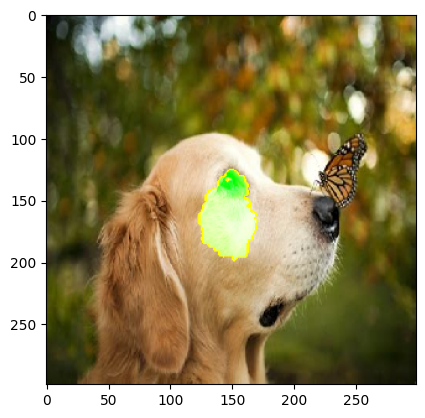

In [81]:
# Change the index value to explain different labels
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

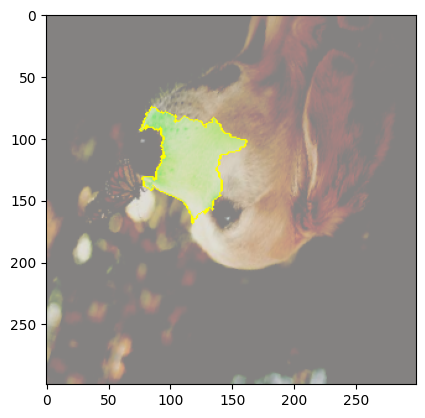

In [82]:
temp, mask = aug_explanation.get_image_and_mask(aug_explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Heat Map

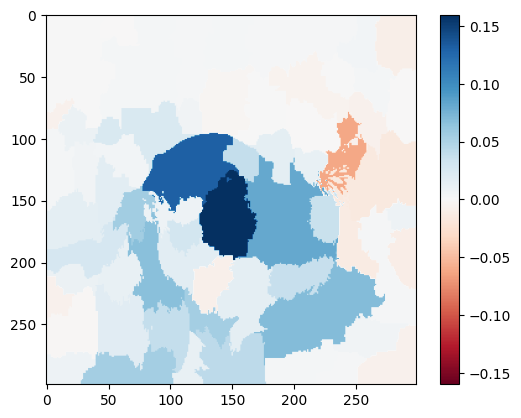

In [49]:
# Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

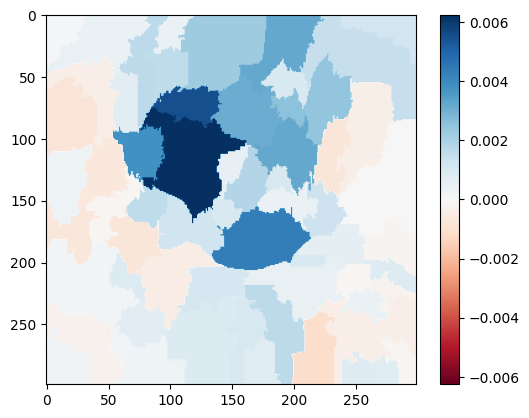

In [50]:
# Select the same class explained on the figures above.
ind =  aug_explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(aug_explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(aug_explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()